# DETECTR 011 Analysis
This notebook is for formatting, analyzing and plotting the DETECTR_011 data. 

## Objective
Test all varying gDNA background, varying gRNA concentration and varying reporter concentration

## Formatting to CSV file
Take txt file from plate reader and turn into tidy data format

In [43]:
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

import holoviews as hv
import bokeh
import hvplot.pandas

In [44]:
#read in CSV file
DETECTR_raw = pd.read_csv("../raw_txt_files/DETECTR_011.txt", encoding='utf-16', sep="\t", delimiter="\t",index_col=None, skiprows= 3,header = None)

In [45]:
DETECTR_raw.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
5772,NaN,NaN,13.158,2.717,13.871,2.904,12.260,2.861,2.616,2.700,...,4.704,3.341,4.901,3.158,4.091,2.982,4.544,3.071,NaN,NaN
5773,NaN,NaN,2.885,2.751,2.920,2.819,2.872,2.829,2.848,2.745,...,2.980,2.890,2.935,3.179,3.043,2.916,3.072,2.847,NaN,NaN
5774,NaN,NaN,16.848,2.880,10.537,2.900,14.010,2.800,10.741,2.876,...,3.781,3.158,5.478,2.954,4.485,3.069,5.124,3.286,NaN,NaN
5775,NaN,NaN,2.965,3.036,2.942,2.997,3.313,3.062,2.876,2.919,...,2.998,3.130,3.514,3.042,3.346,3.311,3.079,3.066,NaN,NaN
5776,~End,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5777,Original Filename: DETECTR_011; Date Last Save...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5778,Workflow:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5779,"-Set Temperature: IsTemperatureControlOn=""True...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5780,"-Read: ExperimentNameToRead=""Expt1"" SectionNam...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5781,"-Set Temperature: IsTemperatureControlOn=""True...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#drop unnecessary rows at the end of the csv
DETECTR_raw = DETECTR_raw.drop(list(range(len(DETECTR_raw)-6, len(DETECTR_raw))), axis=0)

In [47]:
#select only the first columns
DETECTR_raw = DETECTR_raw.iloc[:,0:26]

In [48]:
#how many plate reads did we have?
len(DETECTR_raw)/16

361.0

In [49]:
#set a variable to identify the number of plate reads
num_plate_reads = int(len(DETECTR_raw)/16)

In [50]:
#create a dictionary mapping the row number to a letter for 384 and 96
well_dict_384 = {1:"A",2:"B",3:"C",4:"D",5:"E",6:"F",7:"G",8:"H",9:"I",10:"J",11:"K",12:"L",13:"M",14:"N",15:"O",16:"P"}
well_dict_96 = {1:"A",2:"A",3:"B",4:"B",5:"C",6:"C",7:"D",8:"D",9:"E",10:"E",11:"F",12:"F",13:"G",14:"G",15:"H",16:"H"}

In [51]:
#initialize the cleaned data frame
DETECTR_cleaned = pd.DataFrame(columns = ['time','row_384','column_384', 'row_96','column_96','rfu_value'])

In [52]:
DETECTR_raw.head(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,00:00:00,37.0,216.216,3.335,203.494,3.342,160.627,3.079,63.707,3.726,...,9.941,3.411,5.582,3.274,3.828,3.291,3.464,3.717,2.910,3.327
1,NaN,NaN,3.265,3.387,3.306,3.009,3.286,3.208,2.945,3.241,...,3.337,3.361,3.432,3.293,3.356,3.229,3.489,3.459,10.011,3.310
2,NaN,NaN,223.842,3.182,158.651,3.028,95.902,2.941,55.937,2.948,...,6.389,3.293,4.454,3.286,3.316,3.357,3.414,3.448,3.063,4.216
3,NaN,NaN,3.263,3.747,3.226,2.969,3.077,3.940,3.093,3.193,...,3.083,3.060,3.249,3.327,3.245,3.349,3.593,3.505,3.489,3.860
4,NaN,NaN,277.912,3.207,260.736,3.173,155.667,2.995,126.721,2.977,...,13.563,2.974,5.812,3.071,3.733,3.324,3.662,3.645,3.355,3.459
5,NaN,NaN,3.400,2.949,3.179,2.948,3.056,2.991,2.801,2.901,...,3.053,3.026,2.990,2.944,3.299,3.182,3.421,3.438,3.657,3.314
6,NaN,NaN,232.588,2.996,162.618,2.875,98.565,3.043,57.639,2.978,...,6.452,2.985,4.403,2.988,3.202,3.149,3.081,3.189,3.843,5.828
7,NaN,NaN,3.427,3.080,3.181,2.990,3.036,2.653,2.943,2.990,...,3.067,2.837,3.268,3.053,3.052,3.269,3.387,4.761,3.465,3.429
8,NaN,NaN,3.645,3.234,4.225,2.709,3.561,2.872,3.666,3.011,...,3.623,3.055,4.383,3.054,3.423,3.278,4.513,3.263,4.129,3.327
9,NaN,NaN,3.447,3.114,3.100,2.964,2.942,2.824,3.420,3.018,...,3.207,3.094,3.045,3.063,2.976,3.032,3.403,3.320,3.483,3.268


In [53]:
#iterate over each plate to create a dataframe with the correct time, the 384 and 96 position and the RFU_value
for i in list(range(0,num_plate_reads)):
    time = DETECTR_raw.iloc[i*16,0]
    for j in list(range(2, 26)):
        for k in list(range(i*16, i*16+16)):
            rfu_value = DETECTR_raw.loc[k,j]
            row_384 = well_dict_384[k%16+1]
            column_384 = j-1
            row_96 = well_dict_96[k%16+1]
            column_96 = j // 2
            DETECTR_cleaned.loc[len(DETECTR_cleaned)] = [time, row_384, column_384,row_96,column_96,rfu_value]

KeyboardInterrupt: 

In [ ]:
#how many rows in our data frame now? should be 384*number of plates
len(DETECTR_cleaned)

In [20]:
#write this file to a CSV
DETECTR_cleaned.to_csv("../DETECTR_011_tidy.csv")

In [55]:
DETECTR_cleaned = pd.read_csv("../tidy_data/DETECTR_011_tidy.csv", index_col=0)
DETECTR_cleaned.head(5)

,time,row_384,column_384,row_96,column_96,rfu_value
0,00:00:00,A,1,A,1,216.216
1,00:00:00,B,1,A,1,3.265
2,00:00:00,C,1,B,1,223.842
3,00:00:00,D,1,B,1,3.263
4,00:00:00,E,1,C,1,277.912


## Filter the data frame
Select only wells we are interested in

In [56]:
def filter_time(DETECTR_cleaned, time):
    DETECTR = DETECTR_cleaned.loc[DETECTR_cleaned["time"]==time]
    DETECTR = DETECTR.loc[(DETECTR["column_384"]%2 == 1) & (DETECTR["row_384"].isin(['A','C','E','G','I','K','M','O']))]
    DETECTR = DETECTR.assign(well=(DETECTR['row_96'] + DETECTR['column_96'].map(str)))
    DETECTR_reporter = DETECTR.loc[DETECTR['row_96'].isin (['A','B','C','D'])]
    DETECTR_reporter = DETECTR_reporter.assign(stock_conc=[100]*4+[50]*4+[25]*4+[12.5]*4+[6.25]*4+[3.125]*4+[1.56]*4+[0.78]*4+[0.39]*4+[0.195]*4+[0.0975]*4+[0]*4)
    DETECTR_reporter = DETECTR_reporter.assign(gRNA=['12G','12G','11B','11B']*12)
    DETECTR_reporter = DETECTR_reporter.assign (target_added=['target added','no target']*24)
    return DETECTR_reporter

In [57]:
DETECTR_2hr_reporter = filter_time(DETECTR_cleaned, "02:00:00")
DETECTR_2hr_reporter.head(10)

,time,row_384,column_384,row_96,column_96,rfu_value,well,stock_conc,gRNA,target_added
23040,02:00:00,A,1,A,1,258.734,A1,100.0,12G,target added
23042,02:00:00,C,1,B,1,249.304,B1,100.0,12G,no target
23044,02:00:00,E,1,C,1,850.541,C1,100.0,11B,target added
23046,02:00:00,G,1,D,1,263.959,D1,100.0,11B,no target
23072,02:00:00,A,3,A,2,692.844,A2,50.0,12G,target added
23074,02:00:00,C,3,B,2,197.821,B2,50.0,12G,no target
23076,02:00:00,E,3,C,2,1504.263,C2,50.0,11B,target added
23078,02:00:00,G,3,D,2,201.224,D2,50.0,11B,no target
23104,02:00:00,A,5,A,3,738.058,A3,25.0,12G,target added
23106,02:00:00,C,5,B,3,131.252,B3,25.0,12G,no target


In [58]:
DETECTR_2hr_reporter.hvplot.scatter(x = 'stock_conc', y = 'rfu_value', xlabel = 'reporter stock concentration (uM)', by = 'target_added', groupby = 'gRNA', hover_cols = ['well','gRNA'], rot = 90, width = 500)

:DynamicMap   [gRNA]
   :NdOverlay   [target_added]
      :Scatter   [stock_conc]   (rfu_value,well,gRNA)

In [59]:
DETECTR_30min_reporter = filter_time(DETECTR_cleaned, "00:30:00")

In [60]:
DETECTR_30min_reporter.hvplot.scatter(x = 'stock_conc', y = 'rfu_value', xlabel = 'reporter stock concentration (uM)', by = 'target_added', groupby = 'gRNA', hover_cols = ['well','gRNA'], rot = 90, width = 500)

:DynamicMap   [gRNA]
   :NdOverlay   [target_added]
      :Scatter   [stock_conc]   (rfu_value,well,gRNA)

In [61]:
#only select rows with the 6 hour time point 
#(this was the point in which most samples hadn't dried out yet, but had peaked)
DETECTR_4hr = DETECTR_cleaned.loc[DETECTR_cleaned["time"]=="04:00:00"]

In [62]:
#select only wells in quadrant A1
DETECTR_4hr = DETECTR_4hr.loc[(DETECTR_4hr["column_384"]%2 == 1) & (DETECTR_4hr["row_384"].isin(['A','C','E','G','I','K','M','O']))]

In [63]:
#identify the background fluorescent which is our negative control (Well O23)
background = DETECTR_4hr.loc[(DETECTR_4hr["column_384"] == 23) & (DETECTR_4hr["row_384"] == "O")]['rfu_value']
background

46446    3.755
Name: rfu_value, dtype: float64

In [64]:
#subtract that value from the rfu_value for each well and add to a new column
DETECTR_4hr['rfu_value_bkgrd_sub'] = DETECTR_4hr['rfu_value'].map(float) - list(background)

In [65]:
DETECTR_4hr['rfu_value_bkgrd_sub'].head(10)

46080     284.685
46082     269.793
46084    1377.860
46086     285.978
46088      -0.623
46090       0.274
46092       6.051
46094       9.837
46112    1048.105
46114     232.455
Name: rfu_value_bkgrd_sub, dtype: float64

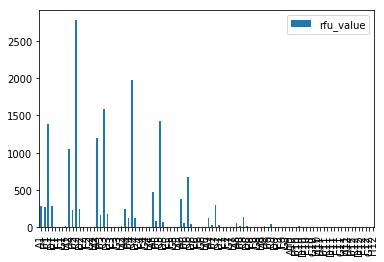

In [66]:
#plot the background subtracted RFU_values for each well as a barplot
DETECTR_4hr.plot(x = DETECTR_4hr['row_96'] + DETECTR_4hr['column_96'].map(str), y= 'rfu_value', kind = 'bar')

In [67]:
#which rfu are less than the background?
#DETECTR_6hr.loc[DETECTR_6hr['rfu_value_bkgrd_sub']<0]

In [68]:
DETECTR_4hr['well'] = DETECTR_4hr['row_96'] + DETECTR_4hr['column_96'].map(str)

In [69]:
DETECTR_4hr.hvplot(x = 'well', y = 'rfu_value', kind = 'bar', rot = 90, width = 1000)

:Bars   [well]   (rfu_value)

In [70]:
DETECTR_4hr_reporter = DETECTR_4hr.loc[DETECTR_4hr['row_96'].isin (['A','B','C','D'])]

In [71]:
DETECTR_4hr_reporter = DETECTR_4hr_reporter.assign(stock_conc=[100]*4+[50]*4+[25]*4+[12.5]*4+[6.25]*4+[3.125]*4+[1.56]*4+[0.78]*4+[0.39]*4+[0.195]*4+[0.0975]*4+[0]*4)

In [72]:
DETECTR_4hr_reporter = DETECTR_4hr_reporter.assign(gRNA=['12G','12G','11B','11B']*12)

In [73]:
DETECTR_4hr_reporter=DETECTR_4hr_reporter.assign (target_added=['target added','no target']*24)

In [74]:
DETECTR_4hr_reporter.hvplot.scatter(x = 'stock_conc', y = 'rfu_value', xlabel = 'reporter stock concentration (uM)', by = 'target_added', groupby = 'gRNA', hover_cols = ['well','gRNA'], rot = 90, width = 500)

:DynamicMap   [gRNA]
   :NdOverlay   [target_added]
      :Scatter   [stock_conc]   (rfu_value,well,gRNA)

In [75]:
DETECTR_4hr_gDNA = DETECTR_4hr.loc[DETECTR_4hr['row_96'].isin (['E','F'])]

In [76]:
DETECTR_4hr_gDNA = DETECTR_4hr_gDNA.assign(stock_conc=[360]*2+[180]*2+[90]*2+[45]*2+[22.5]*2+[11.25]*2+[5.625]*2+[2.8125]*2+[1.40625]*2+[0.703125]*2+[0]*2+[0]*2)

In [77]:
DETECTR_4hr_gDNA=DETECTR_4hr_gDNA.assign(gRNA=['11A','11E']*12)

In [78]:
DETECTR_4hr_gDNA=DETECTR_4hr_gDNA.assign(target_added=['target added']*22+['no target']*2)

In [79]:
DETECTR_4hr_gDNA.hvplot.scatter(title = 'gDNA',x = 'stock_conc', y = 'rfu_value', by = 'target_added',groupby='gRNA', hover_cols = ['well'],rot = 90, width = 500)

:DynamicMap   [gRNA]
   :NdOverlay   [target_added]
      :Scatter   [stock_conc]   (rfu_value,well)

In [80]:
DETECTR_4hr_crRNA = DETECTR_4hr.loc[DETECTR_4hr['row_96'].isin (['G','H'])]

In [81]:
DETECTR_4hr_crRNA=DETECTR_4hr_crRNA.assign(stock_conc=[1000]*2+[500]*2+[250]*2+[125]*2+[62.5]*2+[31.125]*2+[15.625]*2+[7.8125]*2+[3.9]*2+[1.95]*2+[0.98]*2+[0]*2)

In [82]:
DETECTR_4hr_crRNA=DETECTR_4hr_crRNA.assign(gRNA=['11A','11E']*12)

In [83]:
DETECTR_4hr_crRNA.hvplot.scatter(title = 'crRNA',x = 'stock_conc', y = 'rfu_value', by='gRNA',hover_cols = ['well'],rot = 90, width = 500)

:NdOverlay   [gRNA]
   :Scatter   [stock_conc]   (rfu_value,well)

In [84]:
DETECTR_quadA1 = DETECTR_cleaned.loc[(DETECTR_cleaned["column_384"]%2 == 1) & (DETECTR_cleaned["row_384"].isin(['A','C','E','G','I','K','M','O']))]

In [85]:
DETECTR_quadA1=DETECTR_quadA1.assign(well=DETECTR_quadA1['row_96'] + DETECTR_quadA1['column_96'].map(str))

In [86]:
DETECTR_quadA1.hvplot.line(title = 'kinetics',x = 'time', y = 'rfu_value', by='column_96', groupby='row_96',hover_cols = ['well'],rot = 90, height = 500,width = 500)

:DynamicMap   [row_96]
   :NdOverlay   [column_96]
      :Curve   [time]   (rfu_value,well)

## Conclusions
1. Need to repeat gDNA experiment - crRNA guide or reporter concentration too low, too much noise
2. Reporter concentration definitely increases signal - the relationship gets messier the higher you go. Maybe want to stick with 10uM
3. crRNA also increasees the signal - try this experiment again with more gRNAs and with higher reporter concentration